<a href="https://colab.research.google.com/github/Boonyaratt/Two-Tower-Recommendation/blob/master/data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Two-Tower Recommendation System for Coupon Recommendation

This notebook implements a Two-Tower recommendation system using TensorFlow Recommenders for coupon recommendation analysis.

## Dataset Overview
- **Transaction Data**: Customer purchase history
- **Coupon Data**: Available coupons and their details
- **Household Demographics**: Customer demographic information
- **Product Data**: Product information and categories

## Model Architecture
- **User Tower**: Encodes user/household information
- **Item Tower**: Encodes coupon/product information
- **Retrieval Task**: Learns to match users with relevant coupons


In [7]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [8]:
!pip -q install --upgrade pip setuptools wheel

# 1) แกนหลักที่เข้าชุดกันบน Py3.12
!pip -q install "numpy==1.26.4" "ml-dtypes==0.3.2"

# 3) Install TensorFlow 2.16.1
!pip -q install "tensorflow==2.16.1"

# 4) Install TFRS 0.7.3
!pip -q install "tensorflow-recommenders==0.7.3"

In [9]:
# Import required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
from datetime import datetime, timedelta
from typing import Dict, Text
import os, kagglehub
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("TensorFlow Recommenders version:", tfrs.__version__)
print("Pandas version:", pd.__version__)
print("NumPy version:", np.__version__)


TensorFlow version: 2.16.1
TensorFlow Recommenders version: v0.7.3
Pandas version: 2.2.2
NumPy version: 1.26.4


In [10]:
!mkdir Dataset

mkdir: cannot create directory ‘Dataset’: File exists


In [11]:
os.environ["KAGGLEHUB_CACHE"] = "/content/Dataset"   # any folder you want
kaggle_path = kagglehub.dataset_download("frtgnn/dunnhumby-the-complete-journey")

print("Path to dataset files:", kaggle_path)

Using Colab cache for faster access to the 'dunnhumby-the-complete-journey' dataset.
Path to dataset files: /kaggle/input/dunnhumby-the-complete-journey


In [12]:
# Read all CSV files

path = "/content/Dataset/datasets/frtgnn/dunnhumby-the-complete-journey/versions/1/"

campaign_desc = pd.read_csv(path + "campaign_desc.csv")
campaign_table = pd.read_csv(path + "campaign_table.csv")
coupon_redempt = pd.read_csv(path + "coupon_redempt.csv") ## 1 counpon_unc can have multiple product_id: 556 nunique from 2318
coupon = pd.read_csv(path + "coupon.csv")
hh_demographic = pd.read_csv(path + "hh_demographic.csv")
product = pd.read_csv(path + "product.csv")
transaction_data = pd.read_csv(path + "transaction_data.csv")
# Check the dataframes
print("DataFrames loaded successfully!")
print(f"campaign_desc shape: {campaign_desc.shape}")
print(f"campaign_table shape: {campaign_table.shape}")
print(f"coupon_redempt shape: {coupon_redempt.shape}")
print(f"coupon shape: {coupon.shape}")
print(f"hh_demographic shape: {hh_demographic.shape}")
print(f"product shape: {product.shape}")
print(f"transaction_data shape: {transaction_data.shape}")



DataFrames loaded successfully!
campaign_desc shape: (30, 4)
campaign_table shape: (7208, 3)
coupon_redempt shape: (2318, 4)
coupon shape: (124548, 3)
hh_demographic shape: (801, 8)
product shape: (92353, 7)
transaction_data shape: (2595732, 12)


In [13]:
# Show headers for each dataset
print("Headers for each dataset:")
print("=" * 50)

datasets = {
    'campaign_desc': campaign_desc,
    'campaign_table': campaign_table,
    'coupon_redempt': coupon_redempt,
    'coupon': coupon,
    'hh_demographic': hh_demographic,
    'product': product,
    'transaction_data': transaction_data
}

for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"Columns: {list(df.columns)}")


Headers for each dataset:

campaign_desc:
Columns: ['DESCRIPTION', 'CAMPAIGN', 'START_DAY', 'END_DAY']

campaign_table:
Columns: ['DESCRIPTION', 'household_key', 'CAMPAIGN']

coupon_redempt:
Columns: ['household_key', 'DAY', 'COUPON_UPC', 'CAMPAIGN']

coupon:
Columns: ['COUPON_UPC', 'PRODUCT_ID', 'CAMPAIGN']

hh_demographic:
Columns: ['AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC', 'HOMEOWNER_DESC', 'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC', 'household_key']

product:
Columns: ['PRODUCT_ID', 'MANUFACTURER', 'DEPARTMENT', 'BRAND', 'COMMODITY_DESC', 'SUB_COMMODITY_DESC', 'CURR_SIZE_OF_PRODUCT']

transaction_data:
Columns: ['household_key', 'BASKET_ID', 'DAY', 'PRODUCT_ID', 'QUANTITY', 'SALES_VALUE', 'STORE_ID', 'RETAIL_DISC', 'TRANS_TIME', 'WEEK_NO', 'COUPON_DISC', 'COUPON_MATCH_DISC']


In [14]:
hh_demographic.head(10)
hh_demographic.drop(["AGE_DESC",
                     "MARITAL_STATUS_CODE",
                     "INCOME_DESC",
                     "HH_COMP_DESC",
                     "HOUSEHOLD_SIZE_DESC",
                     "KID_CATEGORY_DESC",],
                    axis=1,inplace = True)

In [15]:
campaign_desc.head()


,DESCRIPTION,CAMPAIGN,START_DAY,END_DAY
0,TypeB,24,659,719
1,TypeC,15,547,708
2,TypeB,25,659,691
3,TypeC,20,615,685
4,TypeB,23,646,684


In [16]:
# Create timestamp feature from DAY and TRANS_TIME
def create_timestamp(day, trans_time):
    """Convert DAY and TRANS_TIME to datetime timestamp"""
    # DAY appears to be day number from some reference point
    # TRANS_TIME is in HHMM format (e.g., 1631 = 16:31)
    base_date = datetime(2010, 3, 24)  # Arbitrary base date
    date_part = base_date + timedelta(days=int(day) - 1)

    # Convert TRANS_TIME to time
    hours = int(trans_time) // 100
    minutes = int(trans_time) % 100
    time_part = timedelta(hours=hours, minutes=minutes)

    return date_part + time_part

# Add timestamp to transaction_data
transaction_data['timestamp'] = transaction_data.apply(
    lambda row: create_timestamp(row['DAY'], row['TRANS_TIME']), axis=1
)


In [17]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2595732 entries, 0 to 2595731
Data columns (total 13 columns):
 #   Column             Dtype         
---  ------             -----         
 0   household_key      int64         
 1   BASKET_ID          int64         
 2   DAY                int64         
 3   PRODUCT_ID         int64         
 4   QUANTITY           int64         
 5   SALES_VALUE        float64       
 6   STORE_ID           int64         
 7   RETAIL_DISC        float64       
 8   TRANS_TIME         int64         
 9   WEEK_NO            int64         
 10  COUPON_DISC        float64       
 11  COUPON_MATCH_DISC  float64       
 12  timestamp          datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(8)
memory usage: 257.5 MB


In [18]:
coupon_redempt = coupon_redempt.merge(
    coupon[['COUPON_UPC', 'PRODUCT_ID']],
    on='COUPON_UPC',
    how='left'
)

In [19]:
coupon_redempt.head()

,household_key,DAY,COUPON_UPC,CAMPAIGN,PRODUCT_ID
0,1,421,10000085364,8,100512
1,1,421,10000085364,8,527731
2,1,421,10000085364,8,1054539
3,1,421,10000085364,8,802268
4,1,421,10000085364,8,846907


In [20]:
transaction_with_coupons = transaction_data.merge(
    coupon_redempt,
    on=['household_key', 'DAY', 'PRODUCT_ID'],
    how='left'
)

In [21]:
transaction_with_coupons

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,timestamp,COUPON_UPC,CAMPAIGN
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0,2010-03-24 16:31:00,NaN,NaN
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0,2010-03-24 16:31:00,NaN,NaN
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0,2010-03-24 16:31:00,NaN,NaN
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0,2010-03-24 16:31:00,NaN,NaN
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0,2010-03-24 16:31:00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2598065,1598,42305362535,711,92130,1,0.99,3228,0.00,1520,102,0.0,0.0,2012-03-03 15:20:00,NaN,NaN
2598066,1598,42305362535,711,114102,1,8.89,3228,0.00,1520,102,0.0,0.0,2012-03-03 15:20:00,NaN,NaN
2598067,1598,42305362535,711,133449,1,6.99,3228,0.00,1520,102,0.0,0.0,2012-03-03 15:20:00,NaN,NaN
2598068,1598,42305362535,711,6923644,1,4.50,3228,-0.49,1520,102,0.0,0.0,2012-03-03 15:20:00,NaN,NaN


In [22]:
transaction_with_coupons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2598070 entries, 0 to 2598069
Data columns (total 15 columns):
 #   Column             Dtype         
---  ------             -----         
 0   household_key      int64         
 1   BASKET_ID          int64         
 2   DAY                int64         
 3   PRODUCT_ID         int64         
 4   QUANTITY           int64         
 5   SALES_VALUE        float64       
 6   STORE_ID           int64         
 7   RETAIL_DISC        float64       
 8   TRANS_TIME         int64         
 9   WEEK_NO            int64         
 10  COUPON_DISC        float64       
 11  COUPON_MATCH_DISC  float64       
 12  timestamp          datetime64[ns]
 13  COUPON_UPC         float64       
 14  CAMPAIGN           float64       
dtypes: datetime64[ns](1), float64(6), int64(8)
memory usage: 297.3 MB


In [23]:
transactions_with_coupons_sum = transaction_with_coupons['COUPON_UPC'].notna().sum()
print(f"Transactions with coupon information: {transactions_with_coupons_sum:,}")
print(f"Percentage of transactions with coupons: {transactions_with_coupons_sum/len(transaction_with_coupons)*100:.2f}%")


Transactions with coupon information: 6,607
Percentage of transactions with coupons: 0.25%


In [24]:
transaction_with_coupons["SALES_VALUE"] = transaction_with_coupons["SALES_VALUE"] - transaction_with_coupons["RETAIL_DISC"]
transaction_with_coupons.drop("RETAIL_DISC", axis=1, inplace=True)
transaction_with_coupons["Use_Coupon"] = transaction_with_coupons["COUPON_UPC"].notna().astype(int)
transaction_with_coupons

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,timestamp,COUPON_UPC,CAMPAIGN,Use_Coupon
0,2375,26984851472,1,1004906,1,1.99,364,1631,1,0.0,0.0,2010-03-24 16:31:00,NaN,NaN,0
1,2375,26984851472,1,1033142,1,0.82,364,1631,1,0.0,0.0,2010-03-24 16:31:00,NaN,NaN,0
2,2375,26984851472,1,1036325,1,1.29,364,1631,1,0.0,0.0,2010-03-24 16:31:00,NaN,NaN,0
3,2375,26984851472,1,1082185,1,1.21,364,1631,1,0.0,0.0,2010-03-24 16:31:00,NaN,NaN,0
4,2375,26984851472,1,8160430,1,1.89,364,1631,1,0.0,0.0,2010-03-24 16:31:00,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2598065,1598,42305362535,711,92130,1,0.99,3228,1520,102,0.0,0.0,2012-03-03 15:20:00,NaN,NaN,0
2598066,1598,42305362535,711,114102,1,8.89,3228,1520,102,0.0,0.0,2012-03-03 15:20:00,NaN,NaN,0
2598067,1598,42305362535,711,133449,1,6.99,3228,1520,102,0.0,0.0,2012-03-03 15:20:00,NaN,NaN,0
2598068,1598,42305362535,711,6923644,1,4.99,3228,1520,102,0.0,0.0,2012-03-03 15:20:00,NaN,NaN,0


## Retrival Candidate

In [25]:
# Fix for StringLookup layer - convert household_key to strings
# First, let's get the unique household keys and convert them to strings
# unique_household_key = list(transaction_data['household_key'].unique().astype(str))
# unique_coupon_upc = list(coupon["COUPON_UPC"].dropna().unique().astype(str))

# embedding_dimension = 32

# context_model = tf.keras.Sequential([
#     tf.keras.Input(shape=(), dtype=tf.string),
#     tf.keras.layers.StringLookup(vocabulary=unique_household_key,
#                                  mask_token=None, num_oov_indices=1),
#     tf.keras.layers.Embedding(len(unique_household_key)+1, embedding_dimension),
# ])

# coupon_model = tf.keras.Sequential([
#     tf.keras.Input(shape=(), dtype=tf.string),
#     tf.keras.layers.StringLookup(vocabulary=unique_coupon_upc,
#                                  mask_token=None, num_oov_indices=1),
#     tf.keras.layers.Embedding(len(unique_coupon_upc)+1, embedding_dimension),
# ])


In [97]:
users_with_coupons = set(coupon_redempt['household_key'].unique())
transaction_filtered = transaction_data[
    transaction_data['household_key'].isin(users_with_coupons)
].copy()

print(f"Filtered transactions: {len(transaction_filtered):,}")

products_bought = set(transaction_filtered['PRODUCT_ID'].unique())
coupons_redeemed = set(coupon_redempt['COUPON_UPC'].unique())
print(f"Coupons actually redeemed: {len(coupons_redeemed):,}")

Filtered transactions: 910,212
Coupons actually redeemed: 556


In [125]:
positive_examples = coupon_redempt[['household_key', 'COUPON_UPC']].copy()
positive_examples['label'] = 1
positive_examples = positive_examples.drop_duplicates()
print(f"Positive examples: {len(positive_examples):,}")

np.random.seed(42)
negative_examples = []

for user in users_with_coupons:
    # Get coupons this user actually used
    user_coupons = set(positive_examples[positive_examples['household_key'] == user]['COUPON_UPC'])

    # Sample coupons they didn't use (negative examples)
    available_coupons = list(coupons_redeemed - user_coupons)
    if len(available_coupons) > 0:
        # Sample up to 3 negative examples per user (or all available if less than 3)
        n_negatives = min(16, len(available_coupons))
        sampled_coupons = np.random.choice(available_coupons, n_negatives, replace=False)

        for coupon in sampled_coupons:
            negative_examples.append({
                'household_key': user,
                'COUPON_UPC': coupon,
                'label': 0
            })

negative_examples = pd.DataFrame(negative_examples)
print(f"Negative examples: {len(negative_examples):,}")

training_data = pd.concat([positive_examples, negative_examples], ignore_index=True)

print(f"Total training examples: {len(training_data):,}")
print(f"Positive ratio: {len(positive_examples)/len(training_data)*100:.1f}%")

Positive examples: 2,229
Negative examples: 6,944
Total training examples: 9,173
Positive ratio: 24.3%


In [126]:
unique_users = list(training_data['household_key'].unique().astype(str))
unique_coupons = list(training_data['COUPON_UPC'].unique().astype(str))

print(f"Unique users in training: {len(unique_users)}")
print(f"Unique coupons in training: {len(unique_coupons)}")

embedding_dimension = 8

context_model = tf.keras.Sequential([
    tf.keras.Input(shape=(),dtype=tf.string),
    tf.keras.layers.StringLookup(
        vocabulary=unique_users,
        mask_token=None,
        num_oov_indices=1
    ),
    tf.keras.layers.Embedding(len(unique_users)+1,embedding_dimension),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu')
])
# Fixed:
coupon_model = tf.keras.Sequential([
    tf.keras.Input(shape=(),dtype=tf.string),
    tf.keras.layers.StringLookup(
        vocabulary=unique_coupons,
        mask_token=None,
        num_oov_indices=1
    ),
    tf.keras.layers.Embedding(len(unique_coupons)+1,embedding_dimension),  # ✅ FIXED!
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu')
])

Unique users in training: 434
Unique coupons in training: 556


In [127]:
# dataset ของ coupon id เป็น string
candidates_ids_ds = tf.data.Dataset.from_tensor_slices(unique_coupons)

# สำคัญ: batch ก่อน แล้วค่อย map โมเดล
candidates_emb_ds = candidates_ids_ds.batch(64).map(
    coupon_model, num_parallel_calls=tf.data.AUTOTUNE
)

metrics = tfrs.metrics.FactorizedTopK(
    candidates=candidates_emb_ds,
    ks=[1,5,10,20]
)
task = tfrs.tasks.Retrieval(metrics=metrics)


In [128]:
training_data.head()

,household_key,COUPON_UPC,label
0,1,10000085364,1
1,1,51700010076,1
2,1,54200000033,1
3,1,10000085476,1
4,1,54200029176,1


In [129]:

train,test = train_test_split(
    training_data,
    test_size=0.2,
    random_state=42,
    stratify=training_data["label"])

print(f"Train size: {len(train):,}")
print(f"Test size: {len(test):,}")

def df_to_ds(df):
    return tf.data.Dataset.from_tensor_slices(
        {
            "user_id": df["household_key"].astype(str),
            "coupon_id": df["COUPON_UPC"].astype(str)
        }
    )

train_ds = df_to_ds(train)
test_ds = df_to_ds(test)



Train size: 7,338
Test size: 1,835


In [130]:
class Model(tfrs.Model):
    def __init__(self, context_model: tf.keras.Model, coupon_model: tf.keras.Model):
        super().__init__()
        self.context_model: tf.keras.Model = context_model
        self.coupon_model: tf.keras.Model = coupon_model
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: Dict[str, tf.Tensor], training: bool = False) -> tf.Tensor:
        context_embeddings = self.context_model(features["user_id"])
        coupon_embeddings = self.coupon_model(features["coupon_id"])

        # คำนวณ loss + อัปเดต metrics
        return self.task(
            query_embeddings=context_embeddings,
            candidate_embeddings=coupon_embeddings
        )

In [131]:
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, clear_output

class VisualTrainingCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.history = {
            'epoch': [],
            'train_loss': [],
            'val_loss': [],
            'train_top1': [],
            'val_top1': [],
            'train_top5': [],
            'val_top5': [],
            'train_top20': [],
            'val_top20': []
        }

    def on_epoch_end(self, epoch, logs=None):
        # Store metrics
        self.history['epoch'].append(epoch + 1)
        self.history['train_loss'].append(logs.get('loss', 0))
        self.history['val_loss'].append(logs.get('val_loss', 0))
        self.history['train_top1'].append(logs.get('factorized_top_k/top_1_categorical_accuracy', 0))
        self.history['val_top1'].append(logs.get('val_factorized_top_k/top_1_categorical_accuracy', 0))
        self.history['train_top5'].append(logs.get('factorized_top_k/top_5_categorical_accuracy', 0))
        self.history['val_top5'].append(logs.get('val_factorized_top_k/top_5_categorical_accuracy', 0))
        self.history['train_top20'].append(logs.get('factorized_top_k/top_20_categorical_accuracy', 0))
        self.history['val_top20'].append(logs.get('val_factorized_top_k/top_20_categorical_accuracy', 0))

        # Create visualizations
        self.plot_training_progress()
        self.print_epoch_summary(epoch + 1, logs)

    def plot_training_progress(self):
        clear_output(wait=True)
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Reduced from (15, 10)

        epochs = self.history['epoch']

        # Loss plot
        axes[0,0].plot(epochs, self.history['train_loss'], 'b-', label='Train', linewidth=2)
        axes[0,0].plot(epochs, self.history['val_loss'], 'r-', label='Validation', linewidth=2)
        axes[0,0].set_title('Loss Progress', fontsize=12, fontweight='bold')  # Reduced font size
        axes[0,0].set_xlabel('Epoch')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # Top-1 Accuracy
        axes[0,1].plot(epochs, self.history['train_top1'], 'b-', label='Train', linewidth=2)
        axes[0,1].plot(epochs, self.history['val_top1'], 'r-', label='Validation', linewidth=2)
        axes[0,1].set_title('Top-1 Accuracy', fontsize=12, fontweight='bold')
        axes[0,1].set_xlabel('Epoch')
        axes[0,1].set_ylabel('Accuracy')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

        # Top-5 Accuracy
        axes[1,0].plot(epochs, self.history['train_top5'], 'b-', label='Train', linewidth=2)
        axes[1,0].plot(epochs, self.history['val_top5'], 'r-', label='Validation', linewidth=2)
        axes[1,0].set_title('Top-5 Accuracy', fontsize=12, fontweight='bold')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('Accuracy')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)

        # Top-20 Accuracy
        axes[1,1].plot(epochs, self.history['train_top20'], 'b-', label='Train', linewidth=2)
        axes[1,1].plot(epochs, self.history['val_top20'], 'r-', label='Validation', linewidth=2)
        axes[1,1].set_title('Top-20 Accuracy', fontsize=12, fontweight='bold')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Accuracy')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def print_epoch_summary(self, epoch, logs):
        print("=" * 80)
        print(f"🎯 EPOCH {epoch} SUMMARY")
        print("=" * 80)

        # Loss comparison
        train_loss = logs.get('loss', 0)
        val_loss = logs.get('val_loss', 0)
        loss_trend = "📈" if val_loss > train_loss else "📉"

        print(f"📊 LOSS:")
        print(f"   Train: {train_loss:.4f}")
        print(f"   Val:   {val_loss:.4f} {loss_trend}")

        # Accuracy metrics
        print(f"\n🎯 ACCURACY METRICS:")
        metrics = [
            ('Top-1', 'factorized_top_k/top_1_categorical_accuracy', 'val_factorized_top_k/top_1_categorical_accuracy'),
            ('Top-5', 'factorized_top_k/top_5_categorical_accuracy', 'val_factorized_top_k/top_5_categorical_accuracy'),
            ('Top-20', 'factorized_top_k/top_20_categorical_accuracy', 'val_factorized_top_k/top_20_categorical_accuracy')
        ]

        for name, train_key, val_key in metrics:
            train_acc = logs.get(train_key, 0) * 100
            val_acc = logs.get(val_key, 0) * 100
            gap = train_acc - val_acc
            status = "⚠️" if gap > 2 else "✅"

            print(f"   {name:>6}: Train={train_acc:5.2f}%, Val={val_acc:5.2f}% (Gap: {gap:4.1f}%) {status}")

        # Learning rate
        lr = logs.get('lr', 0)
        print(f"\n⚙️  LEARNING RATE: {lr:.6f}")

        # Performance assessment
        val_top20 = logs.get('val_factorized_top_k/top_20_categorical_accuracy', 0) * 100
        if val_top20 > 15:
            print(f"\n🏆 EXCELLENT! Top-20 accuracy: {val_top20:.2f}%")
        elif val_top20 > 10:
            print(f"\n👍 GOOD! Top-20 accuracy: {val_top20:.2f}%")
        elif val_top20 > 5:
            print(f"\n📈 IMPROVING! Top-20 accuracy: {val_top20:.2f}%")
        else:
            print(f"\n🔧 NEEDS WORK! Top-20 accuracy: {val_top20:.2f}%")

        print("=" * 80)

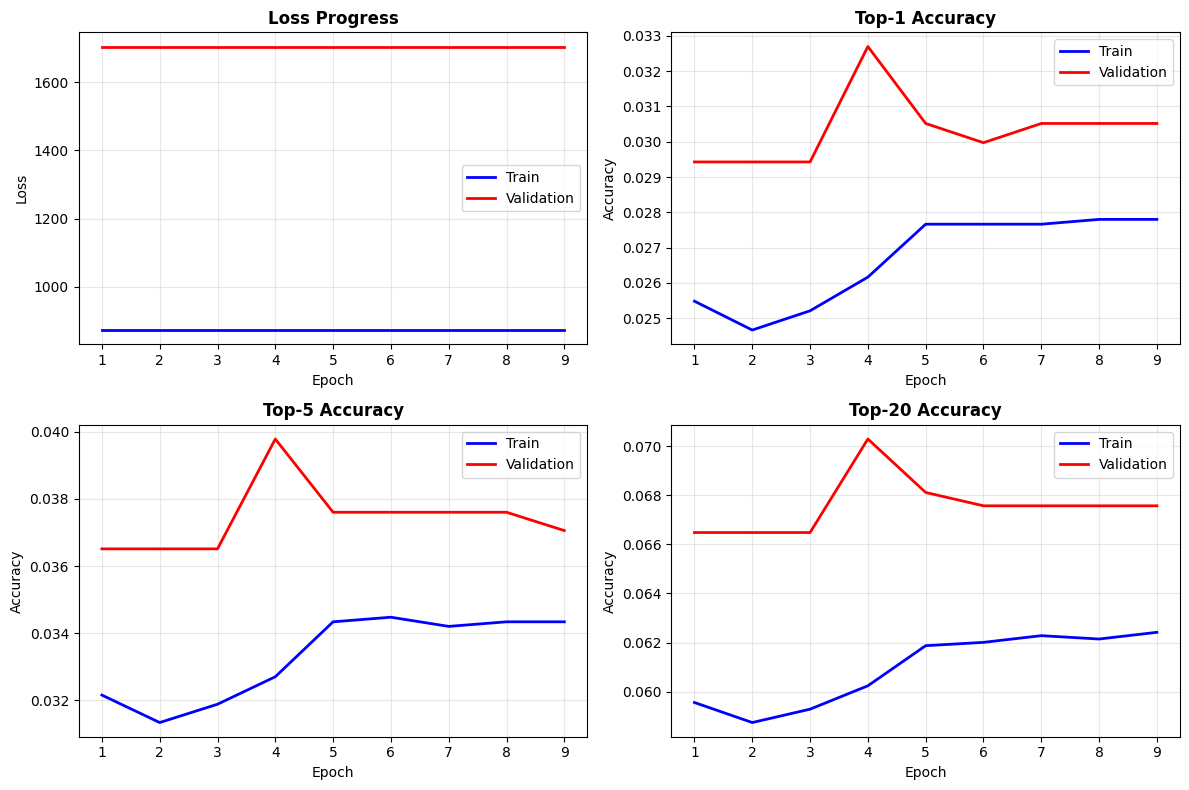

🎯 EPOCH 9 SUMMARY
📊 LOSS:
   Train: 873.0897
   Val:   1704.4310 📈

🎯 ACCURACY METRICS:
    Top-1: Train= 2.78%, Val= 3.05% (Gap: -0.3%) ✅
    Top-5: Train= 3.43%, Val= 3.71% (Gap: -0.3%) ✅
   Top-20: Train= 6.24%, Val= 6.76% (Gap: -0.5%) ✅

⚙️  LEARNING RATE: 0.000081

📈 IMPROVING! Top-20 accuracy: 6.76%


In [132]:
BATCH_SIZE = 512  # Reduced from 4096
EPOCHS = 20  # Reduced from 3 but will be much faster per epoch

cached_train = train_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
cached_test = test_ds.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)
visual_callback = VisualTrainingCallback()

model = Model(context_model, coupon_model)

initial_learning_rate = 0.0001  # Much more stable
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=50,
    decay_rate=0.9,
    staircase=True
)

model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=lr_schedule))

# Include visual callback in the callbacks list
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,  # More patience
        restore_best_weights=True,
        min_delta=0.001
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,  # Reduce LR if no improvement
        min_lr=0.00001
    ),
    visual_callback  # ✅ Add this!
]

# Train with visual feedback
history = model.fit(
    cached_train,
    validation_data=cached_test,
    epochs=EPOCHS,
    callbacks=callbacks,  # This will include visual_callback
    verbose=0  # Use custom display instead
)